# Simple 2D packing example with simple boxes

[Box icon from www.iconfinder.com](https://www.iconfinder.com/icons/4072102/box_delivery_package_parcel_shipping_icon)

Import libraries

In [15]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym
import random

from gym import Env, spaces
import time

font = cv2.FONT_HERSHEY_COMPLEX_SMALL 

In this environment an agent places 2D boxes in a 2D container.
1. The agent needs to pack as many boxes as possible without overlapping them.
2. The episode terminates when the container is full or no more boxes can be placed.

### ContainerLevel Class
Creating a class to model the bottom level of a shipping container.
* Define in the `__init__` function the observation and the action spaces.
* Implement attribute `canvas` 
* Implement screen area `x_min, y_min, x_max, y_max`
* Implement `elements` - this stores elements in the screen (the already packed box)
* helper function `draw_elements_on_canvas` that places the boxes icons in the container at their respective positions
* `reset` : resets the environment to its initial state and returns the initial observation.
* `step`: Executes a step by placing a box in the environment
    * returns the new observation
    * reward
    * completion status
    * and other information

In [40]:
class ContainerLevel(Env):
    def __init__(self):
        super(ContainerLevel, self).__init__()

        # Define 2D packing space
        self.observation_shape = (600, 800, 3) # **Need to have dimensions passed
        self.observation_space = spaces.Box(low = np.zeros(self.observation_space),
                                            high = np.ones(self.observation_space),
                                            dtype = np.float64)

        # Define an action space
        self.action_space = spaces.Discrete(6, ) # what is the 6?

        # Creating a canvas for rendering
        self.canvas = np.ones(self.observation_shape) * 1

        # Define elements present in the environment
        self.elements = []

        # Permissible area where the boxes can be located in container
        # **need to adjust this to be smaller when there are other boxes
        self.y_min = int(self.observation_shape[0] * 0.1)
        self.x_min = 0
        self.y_max = int(self.observation_shape[0] * 0.9)
        self.x_max = self.observation_shape[1]
        self.box_len = int(self.observation_shape[0] * 0.01)
        self.box_wid = int(self.observation_shape[0] * 0.01)

    def draw_elements_on_canvas(self):
        # Initialize the canvas
        self.canvas = np.ones(self.observation_shape)* 1

        # Draw the boxes on the canvas
        for elem in self.elements:
            elem_shape = elem.boxes.shape
            x, y = elem.x, elem.y
            self.canvas[y : y + elem_shape[1],
                        x : x + elem_shape[0]] = elem.boxes
    
    def reset(self):
        # Reset the reward
        self.ep_return = 0

        # Number of boxes
        self.boxes_count = 0

        # Determine a random place to initialize the first box
        # along one side of the container
        x = random.randrange(int(self.observation_shape[0] * 0.0),
                             int(self.observation_shape[0] * 1.0))
        y = random.randrange(int(self.observation_shape[1] * 0.0),
                             int(self.observation_shape[1] * 
                             1.0 )) # Would like to change this to box_len/observation_shape[1]

        # Initialize the boxes
        self.boxes = Boxes('boxes', self.x_max, self.x_min, self.y_max, self.y_min, self.box_len, self.box_wid)
        self.boxes.set_position(x, y)          

        # Intialize the elements
        self.elements = [self.boxes]

        # Reset the canvas
        self.canvas = np.ones(self.observation_shape) * 1

        # Draw elements on the canvas
        self.draw_elements_on_canvas()

        # return the observation of the state of the container
        return self.canvas

### Elements of the Environment - Boxes
* Starting with a `Point` base class to define any arbitrary point in the observation image.
* It has the following attribures:
    * `(x, y)`: position of the point on the image.
    * `(x_min, x_max, y_min, y_max)`: the permissible coordicates for the points - keeps the position values clamped to these limits.
    * `name` : name of the point
* Member functions are defined as:
    * `get_position` : get the coordinate of the point.
    * `set_position` : set the coordinate of the point to a certain value
    * `move` ?  - maybe we can call it `rotate` when we need it?

In [41]:
class Point(object):
    def __init__(self, name, x_max, x_min, y_max, y_min, box_len, box_wid):
        self.x = 0
        self.y = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.box_len = box_len
        self.box_wid = box_wid

    def set_position(self, x, y):
        # use box width (box_wid) and length (box_len)
        # Dimensions will be (x, y, z) so box is (box_len, box_wid, box_high)
        self.x = self.clamp(x, self.x_min, self.x_max - self.box_len)
        self.y = self.clamp(y, self.y_min, self.y_max - self.box_wid)

    def get_position(self):
        return (self.x, self.y)

    # rot_ang is the rotational angle in radians - for 2D: pi/2
    def rotate_xy(self, rot_ang):
        self.x += np.cos(rot_ang)
        self.y += np.sin(rot_ang)

        self.x = self.clamp(self.x, self.x_min, self.x_max - self.box_len)
        self.y = self.clamp(self.y, self.y_min, self.y_max - self.box_wid)

    # Here's the much needed part - clamp - to be sure boxes are in the container
    def clamp(self, n, minn, maxn):
        return (max(min(maxn, n), minn))

### The objects are boxes and need to have the attributes:
* `boxes` - the 2D footprint of a box 
* `(box_len, box_wid)` - the dimensions of the footprint of the box.

In [42]:
class Boxes(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min, box_len, box_wid):
        super(Boxes, self).__init__(name, x_max, x_min, y_max, y_min, box_len, box_wid)
        self.boxes = cv2.imread('./images/4072102_box_delivery_package_parcel_shipping_icon.png') / 255.0
        self.box_len = box_len
        self.box_wid = box_wid
        self.boxes = cv2.resize(self.boxes, (self.box_len, self.box_wid))


#### Observing initial container

/home/cim/anaconda3/envs/packing_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  import sys


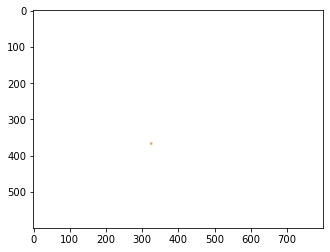

In [43]:
env = ContainerLevel()
obs = env.reset()
plt.imshow(obs)